In [1]:
!wget https://raw.githubusercontent.com/luis-huacho/proyecto-segmentacion-autoetiquetado/refs/heads/master/output/openclip_avocado_labels_4.csv --quiet
!wget https://raw.githubusercontent.com/luis-huacho/proyecto-segmentacion-autoetiquetado/refs/heads/master/avocado_dataset/description.xlsx --quiet

In [2]:
import pandas as pd
from pathlib import Path

# === 1. Rutas de entrada/salida ==============================================
DESCRIPTION_PATH = Path("description.xlsx")
PREDICTIONS_PATH = Path("openclip_avocado_labels_4.csv")
OUTPUT_PATH      = Path("avocado_comparison_results.csv")

# === 2. Cargar datasets =======================================================
desc_df = pd.read_excel(
    DESCRIPTION_PATH,
    usecols=["File Name", "Ripening Index Classification"]
)
pred_df = pd.read_csv(PREDICTIONS_PATH)

# === 3. Preparar claves de unión =============================================
# El CSV trae la extensión; la añadimos a File Name para emparejar.
desc_df["image_name"] = desc_df["File Name"].astype(str).str.strip() + ".jpg"

# Mapear índice 1-5 → etiqueta de clase
index_to_label = {1: "ripe", 2: "ripe",
                  3: "ripe", 4: "ripe",
                  5: "overripe"}
desc_df["actual_label"] = desc_df["Ripening Index Classification"].map(index_to_label)

# === 4. Fusionar y evaluar ====================================================
merged = (desc_df[["image_name", "actual_label"]]
          .merge(pred_df, on="image_name", how="inner"))

merged["correct"] = merged["actual_label"] == merged["predicted_label"]
accuracy = merged["correct"].mean()

confusion = pd.crosstab(
    merged["actual_label"],
    merged["predicted_label"],
    dropna=False
)

# === 5. Guardar resultados detallados ========================================
cols_to_save = ["image_name", "actual_label", "predicted_label", "correct"]
# Añadimos 'confidence' si existe en el CSV de predicciones
if "confidence" in merged.columns:
    cols_to_save.append("confidence")

merged[cols_to_save].to_csv(OUTPUT_PATH, index=False)

# === 6. Mostrar resumen por consola ==========================================
print(f"Imágenes evaluadas: {len(merged):,}")
print(f"Precisión global : {accuracy:.2%}\n")
print("Matriz de confusión:")
print(confusion)

Imágenes evaluadas: 14,710
Precisión global : 82.24%

Matriz de confusión:
predicted_label  overripe   ripe
actual_label                    
overripe              786   2078
ripe                  535  11311


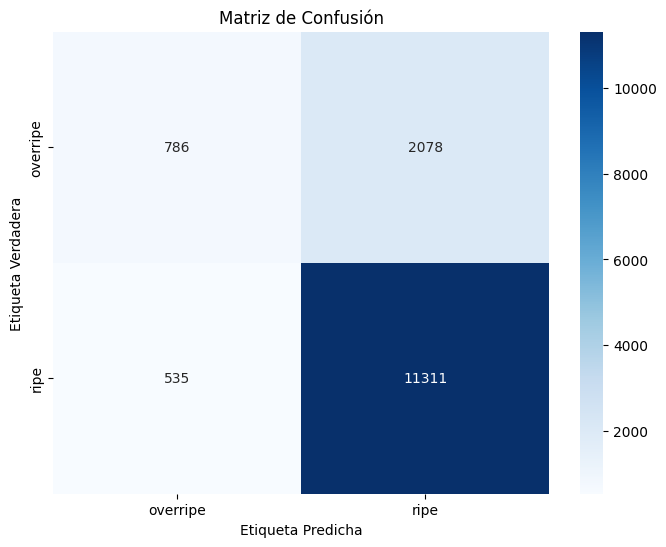


Métricas de Clasificación por Clase:
              precision    recall  f1-score   support

    overripe       0.60      0.27      0.38      2864
        ripe       0.84      0.95      0.90     11846

    accuracy                           0.82     14710
   macro avg       0.72      0.61      0.64     14710
weighted avg       0.80      0.82      0.80     14710



In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# === 7. Graficar Matriz de Confusión ==========================================
# Usamos la matriz de confusión calculada previamente
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# === 8. Mostrar Métricas de Clasificación por Clase ==========================
# Usamos classification_report de scikit-learn para obtener precisión y recall por clase
print("\nMétricas de Clasificación por Clase:")
print(classification_report(merged["actual_label"], merged["predicted_label"]))
